# Diseaseome Data General Analysis and Visualizations

### Import neccesary libraries

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from random import randint
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
#https://www.pnas.org/content/104/21/8685/tab-figures-data

### General Network Analysis Function Definitions

In [2]:
### GENERAL NETWORK ANALYSIS FUNCTIONS

def plotDegsCCDF(Go): #Plots CCDF of degrees given a network
    degrees = Go.degree()
    kmax    = 0
    kis     = []
    # tabulate and display the CCDF Pr(K>=k)
    for _,ki in degrees:
        kis.append(ki)
        if ki > kmax: kmax = ki

    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

def calculateMeanGeodesic(Go):
    n = Go.number_of_nodes()#function for number of nodes
    m = Go.size() #function for number of edges

    dij = dict(nx.all_pairs_shortest_path_length(Go)) # APSP on G, store as a dictionary (tricky :)
    mean_geo_path_per_Node = [] # store average path length from any given nodes
    for i in dij.values(): #iterate through each dict of shortest pathes per node
        node = []
        for x in i.values(): #iterate through shortest pathes for each node
            if x != 0: # if path length doesn't equal zero then append to shortest pathes
                node.append(x)
        if len(node)!=0: #if node has any nodes attached then find the mean shortest path and add to list of all nodes
            mean_geo_path_per_Node.append(np.mean(node))
    ellmean = np.mean(mean_geo_path_per_Node)#add mean of graph to ellms array
    return ellmean

def summaryStats(Go):
    n = Go.number_of_nodes()#function for number of nodes
    m = Go.size() #function for number of edges
    kmean = m*2/n #mean of in directed degree is edges/number of nodes
    ellmean = calculate_MeanGeodesic(Go)
    C = nx.transitivity(Go)# C 

    print(f'number of nodes, n  = {n}')
    print(f'number of edges, m  = {m}')
    print(f'mean degree,    <k> = %5.2f' % kmean)
    print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
    print(f'clustering coefficient, C     = %5.2f' % C)

### Network Editing  Function Definitions

In [15]:
# CUSTOM FUNCTIONS FOR DISEASOME DATA 

# seperateType: takes a bipartite network and takes projects it given a type ('gene' or 'disease' in our case)
def seperateType(Go, IsolateType): # seperate bipartite graph into projections
    G_new = nx.Graph() #make new graph
    
    for i in Go.nodes(): #create edge between i and p, where p is the nodes that i -> other group -> p
        if Go.node[i]['Type'] == IsolateType: #if type we want
            
            neighbors = list(Go.neighbors(i))#make list of neighbors
            compression = len(neighbors)#store the amount of original neighbors and store as attribute
            G_new.add_node(i, Type = Go.node[i]['Type'], Class = Go.node[i]['Class'], 
                                                           Compressed_Neighbors = compression)
            add = {} #before adding second neighbors store the amount of shared (genes or diseases)
            
            for neighbor in neighbors: #For each neighbor find second neighbors
                for second_neighbor in list(Go.neighbors(neighbor)):
                    
                    if second_neighbor in add: #already shared gene so increment
                        add[second_neighbor] = add[second_neighbor] + 1
                        
                    else:
                        add[second_neighbor] = 1 #first time seeing this (gene/disease) so add common connections 1
            
            for key, value in add.items(): #now go through and add edges with found wieghts
                if i != key: #No self loops :P
                    G_new.add_edge(i, key, weight = value)
            
    return G_new #return 1-partite graph
    
# removeSingletons: given a graph return a copy of it without the singletons
def removeSingletons(Go): #this function is to make a new graph without singletons located in input graph
    G_new = Go.copy()
    for i in Go.nodes():
        if G_new.degree(i) == 0: #for every node that has degree 0 delete
            G_new.remove_node(i)
    return G_new

# largestComponent
def largestComponent(Go, bipartite = True): #return a largest subset graph of GO
    G_new = nx.Graph() #new graph
    
    #find LCC and assume it is contained in largest connected subgraph
    max_i = 0
    max_deg = 0
    for i,j in Go.degree():
        if j > max_deg:
            max_deg = j
            max_i = i
        
    #store explored and unexplored nodes
    unexplored_nodes = [max_i]
    current = unexplored_nodes[0]
    explored_nodes = []
    if not bipartite:
        G_new.add_node(current, Type = Go.node[current]['Type'], Class = Go.node[current]['Class'], Compressed_Neighbors = Go.node[current]['Compressed_Neighbors'])
    else:
        G_new.add_node(current, Type = Go.node[current]['Type'], Class = Go.node[current]['Class'])

    while len(unexplored_nodes) > 0:
        # go to front of queue and explore node 0
        current = unexplored_nodes[0] 
        nieghbors = list(Go.neighbors(current))
        for i in nieghbors:# go through neighbors depthfirst and build subgraph
            if i not in unexplored_nodes and i not in explored_nodes:
                unexplored_nodes.append(i)
                if not bipartite:
                    G_new.add_node(i, Type = Go.node[i]['Type'], Class = Go.node[i]['Class'], Compressed_Neighbors = Go.node[i]['Compressed_Neighbors'])
                else:
                    G_new.add_node(i, Type = Go.node[i]['Type'], Class = Go.node[i]['Class'])
                G_new.add_edge(current, i)
                
        unexplored_nodes.remove(current) #delete from unexplored
        explored_nodes.append(current) #add to explored
                               
    return G_new


### Diseasome Plot/Visualization Function Definition

In [4]:
# plotGraph: layout graph to show structure and imitate https://www.pnas.org/content/104/21/8685
def plotGraph(Graph, ColorBy, all_connected = False): #node_size = True,
 
    # Initialize figure
    plt.figure(figsize=(15,15))
    
    # Use spring_layout if not connected, this is because kamada will overlap unconnected sections
    if all_connected:
        pos = nx.kamada_kawai_layout(Graph)
    else:
        pos = nx.spring_layout(Graph, seed = 1, weight = "weight", k= 1/Graph.size()**0.3, iterations = 100)
    
    # Define colors for given category
    if ColorBy == "Type":
        color = {'disease':'#7497bc','gene':'#e78c61'}
        
    elif ColorBy == "Class" :
        color = {'Neurological' : "#e6194B",
                 'Cancer' : "#3cb44b",
                 'Ophthamological' : "#ffe119",
                 'Renal' : "#4363d8",
                 'Metabolic' : "#f58231",
                 'Cardiovascular' : "#911eb4",
                 'Ear,Nose,Throat' : "#42d4f4",
                 'multiple' : "#a9a9a9",
                 'Hematological' : "#bfef45",
                 'Gastrointestinal' : "#fabebe",
                 'Immunological' : "#469990",
                 'Respiratory' : "#e6beff",
                 'Psychiatric' : "#9A6324",
                 'Connective tissue disorder' : "#fffac8",
                 'Muscular' : "#800000",
                 'Nutritional' : "#aaffc3",
                 'Dermatological' : "#808000",
                 'Unclassified' : "#DCDCDC",
                 'Endocrine' : "#000075",
                 'Skeletal' : "#f032e6",
                 'Developmental' : "#013220",
                 'Bone' : "#ffd8b1",
                 'Connective tissue' : "#2F4F4F"}


    # segment nodes into their class so plot at the same time with labels for legend
    seg_nodes = {}
    # create dictionary with keys being Class and values being list of nodes in class
    for i in Graph.nodes():
        if Graph.node[i][ColorBy] not in seg_nodes: #if class has yet to be seen
            seg_nodes[Graph.node[i][ColorBy]] = [i]
        else:
            seg_nodes[Graph.node[i][ColorBy]].append(i) #if class is already in dict
    
#     for key, value in seg_nodes.items(): #go through each class and plot with label and color
#         nx.draw_networkx_nodes(Graph, pos = pos, nodelist = value, node_color = color[key], label = key, node_size = 15)
    
    
    nx.draw_spring(Graph, node_size = [Graph.node[i]["Compressed_Neighbors"]**1.25+15 for i in Graph.nodes()], node_color = [color[Graph.node[i][ColorBy]] for i in Graph.nodes()],
                            k= 1/Graph.size()**0.3, iterations = 100, seed = 1, weight = "weight")
    
    # Attempt at including node size...
    #     sizes = []
    #     colors = []
    #     labels = []
    #     for i in Graph.nodes():        
    #         sizes.append(Graph.node[i]['Compressed_Neighbors'])
    #         colors.append(color[Graph.node[i][ColorBy]])
    #         labels.append(Graph.node[i][ColorBy])
    #     nx.draw_networkx_nodes(Graph, pos = pos, node_color = colors, node_size = sizes)

    #draw them edges
#     nx.draw_networkx_edges(Graph,pos=pos, alpha=0.5)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=value, markersize=15) for key, value in color.items()]
    #plot it
    plt.legend(handles=legend_elements, loc ="best")
    plt.axis('off')
    plt.show()

## Omim Data

Create network using Phenotype name as key for node

In [31]:
df_omim = pd.read_csv("morbidmap.txt",sep='\t')

GO = nx.Graph()
for index, row in df_omim.iterrows():
    GO.add_node(row['# Phenotype'], Type='disease')
    for i in row['Gene Symbols'].split(", "):
        if not GO.has_node(i):
            GO.add_node(i, Type = 'gene')
            
        GO.add_edge(row['# Phenotype'], i)

In [ ]:
plotGraph(GO,"Type")

In [33]:
df_omim.head()

,# Phenotype,Gene Symbols,MIM Number,Cyto Location
0,"17,20-lyase deficiency, isolated, 202110 (3)","CYP17A1, CYP17, P450C17",609300,10q24.32
1,"17-alpha-hydroxylase/17,20-lyase deficiency, 2...","CYP17A1, CYP17, P450C17",609300,10q24.32
2,"2-aminoadipic 2-oxoadipic aciduria, 204750 (3)","DHTKD1, KIAA1630, AMOXAD, CMT2Q",614984,10p14
3,"2-methylbutyrylglycinuria, 610006 (3)","ACADSB, SBCAD",600301,10q26.13
4,"3-M syndrome 1, 273750 (3)","CUL7, 3M1",609577,6p21.1


In [34]:
# Retrieve condensed data set

# Spinal muscular atrophy-1, 253300 (3)
# Spinal muscular atrophy-2, 253550 (3)
# Spinal muscular atrophy-3, 253400 (3)
# Spinal muscular atrophy-4, 271150 (3)
# return Spinal muscular atrophy

# Spinocerebellar ataxia 1, 164400 (3)
# Spinocerebellar ataxia 10, 603516 (3)
# Spinocerebellar ataxia 11, 604432 (3)
# Spinocerebellar ataxia 12, 604326 (3)
# return Spinocerebellar ataxia

prev = ""
diseaseNumber = 10000
diseaseList = []

# Classify diseases in groups based on first word in disease name
for index, row in df_omim.iterrows():
    if prev == "":
        prev = row["# Phenotype"].split(" ")
        diseaseList.append(diseaseNumber)
    else:
        current = row["# Phenotype"].split(" ")
        if current[0] == prev[0]:
            diseaseList.append(diseaseNumber)
        else:
            diseaseNumber = diseaseNumber + 1
            diseaseList.append(diseaseNumber)
        prev = current

df_omim["# Disease ID"] = diseaseList

In [35]:
df_omim.head()

,# Phenotype,Gene Symbols,MIM Number,Cyto Location,# Disease ID
0,"17,20-lyase deficiency, isolated, 202110 (3)","CYP17A1, CYP17, P450C17",609300,10q24.32,10000
1,"17-alpha-hydroxylase/17,20-lyase deficiency, 2...","CYP17A1, CYP17, P450C17",609300,10q24.32,10001
2,"2-aminoadipic 2-oxoadipic aciduria, 204750 (3)","DHTKD1, KIAA1630, AMOXAD, CMT2Q",614984,10p14,10002
3,"2-methylbutyrylglycinuria, 610006 (3)","ACADSB, SBCAD",600301,10q26.13,10003
4,"3-M syndrome 1, 273750 (3)","CUL7, 3M1",609577,6p21.1,10004


In [37]:
# Recreate Network with key as ID
GO = nx.Graph()
for index, row in df_omim.iterrows():
    if not GO.has_node(row['# Disease ID']):
        GO.add_node(row['# Disease ID'], Type='disease', Disorder = row['# Phenotype'])
        
    for i in row['Gene Symbols'].split(", "):
        if not GO.has_node(i):
            GO.add_node(i, Type = 'gene')
            
        GO.add_edge(row['# Disease ID'], i)

In [ ]:
plotGraph(GO,"Type")

### Omim Gene Projection

In [ ]:
# Build Graph
GO_gene = seperateType(GO,'gene')

In [ ]:
plotGraph(GO_gene,"Type")

## Diseaseome Data

In [25]:
# read in diseaseome dataset
df = pd.read_csv("Diseaseome.csv",sep=',')
# Retrieved from https://www.pnas.org/content/104/21/8685

G = nx.Graph()
for index, row in df.iterrows():
    if not G.has_node(row['# Disease ID']):
        G.add_node(row['# Disease ID'], Type='disease', Class = row['Class'], Disorder = row['Disorder name'])
        
    for i in row['Gene symbols'].split(", "):
        if not G.has_node(i):
            G.add_node(i, Type = 'gene', Class = row['Class'])
            
        if G.node[i]['Class'] != row['Class']:
            G.node[i]['Class'] = "multiple"
            
        G.add_edge(row['# Disease ID'], i)
        

In [23]:
unique_class = list(df["Class"].drop_duplicates())
print(unique_class)

['Neurological', 'Cancer', 'Ophthamological', 'Renal', 'Metabolic', 'Cardiovascular', 'Ear,Nose,Throat', 'multiple', 'Hematological', 'Gastrointestinal', 'Immunological', 'Respiratory', 'Psychiatric', 'Connective tissue disorder', 'Muscular', 'Nutritional', 'Dermatological', 'Unclassified', 'Endocrine', 'Skeletal', 'Developmental', 'Bone', 'Connective tissue']


In [10]:
df.head()

,# Disease ID,Disorder name,Gene symbols,OMIM ID,Chromosome,Class,2005 Entrez_ID,in largest Comp.,i,mu
0,1428,"Spinocerebellar ataxia 14, 605361 (3)","PRKCG, PKCC, PKCG, SCA14",176980,19q13.4,Neurological,5582,1,0,0
1,1428,"Spinocerebellar ataxia 4, pure Japanese type, ...",PLEKHG4,609526,16q22.1,Neurological,25894,1,0,542
2,1428,"Spinocerebellar ataxia-27, 609307 (3)","FGF14, FHF4, SCA27",601515,13q34,Neurological,2259,1,0,548
3,1428,"Spinocerebellar ataxia-6, 183086 (3)","CACNA1A, CACNL1A4, SCA6",601011,19p13,Neurological,773,1,0,583
4,1428,"Spinocerebellar ataxia 12, 604326 (3)",PPP2R2B,604325,5q31-q33,Neurological,5521,1,0,799


/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


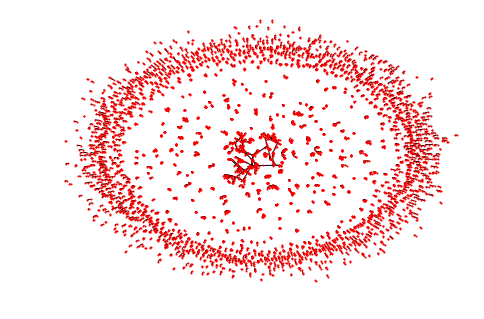

In [11]:
nx.draw_spring(G, with_labels=False, node_size = 1) # draw it pretty
plt.show()

### Bipartite Representation

In [ ]:
plt.figure(figsize=(15,15))
nx.draw_spring(largestComponent(G), with_labels=False, node_size = 2, node_color = bi_graph_colors) # draw it pretty
plt.show()

In [24]:
# test ou
G_gene = seperateType(G,'gene')

KeyError: 'Type'

### Gene Projection

In [ ]:
# Build Graph
G_gene = seperateType(G,'gene')

### Disease Projection

In [ ]:
# Build Graph
G_disease = seperateType(G,'gene')

In [ ]:
plot_graph(G_disease,"Class")

In [ ]:
plot_graph(remove_singletons(G_disease),"Class") 

In [ ]:
plot_graph(largestComponent(G_gene),"Class", all_connected = False)

In [ ]:
largestComponent(G_disease).size()

In [ ]:
plt.figure(figsize=(15,15))
nx.draw_spring(G_gene, with_labels=False,  node_color = get_graph_colors(G_gene, "Type"), node_size = 10) # draw it pretty
plt.show()

In [ ]:
summarystats(G_disease)

In [ ]:
summarystats(G_gene)

In [ ]:
summarystats(G)

In [ ]:
plotDegsCCDF(G)